<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/OUTPUT_SAVE_PED1_ZERO_BG_SUB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imageio
!pip install qpsolvers
!pip install shapely 
#!pip install tensorflow_datasets
!pip install keras-layer-normalization
from google.colab import drive
#!pip install alive-progress
drive.mount('/content/drive', force_remount=True)


  Created wheel for qpsolvers: filename=qpsolvers-1.3-cp36-none-any.whl size=17440 sha256=37bacad72626effa25c6b5f39ec7a8546adab32fe33135f5f07b240f72fa7270
  Stored in directory: /root/.cache/pip/wheels/a3/00/88/2755bd079a831e8d1b38a3e0038cc9d41d0dc907dc97268ff4
  Created wheel for quadprog: filename=quadprog-0.1.7-cp36-cp36m-linux_x86_64.whl size=307614 sha256=2a88bf195dc6a3c4e634d44ede7386da844136653024caf39365ae3a7ab06934
  Stored in directory: /root/.cache/pip/wheels/36/dd/b1/849989444c0a5930927b260663019b7da6cff864fc224c2747
Successfully built qpsolvers quadprog
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5268 sha256=dcba74b6ff1c3910c56a587054df623cb2a01eddd1610a5550046a3d3cf06bf9
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=94731

In [2]:


from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
import statistics
import shutil

import matplotlib.pyplot as plt

import time
#from progress.bar import IncrementalBar

import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Dropout, Activation, InputLayer
from keras.optimizers import Adam
from keras_layer_normalization import LayerNormalization
from keras.models import load_model
import csv
from scipy.interpolate import make_interp_spline, BSpline

from scipy.signal import savgol_filter

Using TensorFlow backend.


In [0]:
def prepend_10_clips(test_case):
    
    test_aug = np.zeros(shape=(test_case.shape[0]+10, 256, 256, 1))
    #print(test_aug.shape)
    #print(test_case.shape)
    for i in range(0,10):
        test_aug[2*i] = test_case[i]
        test_aug[2*i+1] = test_case[i]


    test_aug[20:] = test_case[10:]
    print("Appended test")
    print(test_aug.shape)
    return test_aug


def get_single_test(single_test_path):
    
    sz = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
          sz = sz +1
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            #print("img path: "+join(single_test_path, f))
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    #print(np.array(test).shape)
    
    return prepend_10_clips(np.array(test))

def get_test_sequences(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    print(np.array(test).shape)
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences





In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)

        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"Test/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 50
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = 0
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.latent_dim = 327680


    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")

        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)


conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_AAE_PED1", data_set="UCSD_Anomaly_Dataset.v1p2/UCSDped1/") 


In [0]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/Persistence1D/python')


import matplotlib.pyplot as plt
import numpy as np
from persistence1d import RunPersistence
from reconstruct1d import RunReconstruction
import math    

from shapely.geometry import LineString

In [0]:
TestVideoFile_ped1 = list((36,2))
end = 200
#TestVideoFile_ped1_ori = [[60,152], [50,175], [91,end], [31,168], [5,90], [1,100], [1,175], [1,94], [1,48], [1,140],   [70,165],   [130,end],   [1,156],   [1,end],   [138,end],   [123,end],   [1,47],   [54,120],    [64,138],    [45,175],    [31,end],    [16,107],    [8,165],    [50,171],    [40,135],    [77,144],    [10,122],    [105,end],    [1,15],    [175,end],    [1,180],    [1,52],  [5,165],    [1,121],    [86,end],   [15,108]]


TestVideoFile_ped1 = [[60,152], [50,175], [91,end], [1,168], [5,139], [1,100], [1,175], [1,94], [1,48], [1,140],   [115,end],   [130,end],   [1,156],   [1,end],   [138,end],   [50, 60],   [1,47],   [54,120],    [64,138],    [45,175],    [31,end],    [16,107],    [8,end],    [1,171],    [40,135],    [77,end],    [10,122],    [105,end],    [1,15],    [175,end],    [1,180],    [1,52],  [1,175],    [1,121],    [86,end],   [15,108]]



def SortExtremaByPersistence(ExtremaAndPersistence):
    #~ Sort the list of extrema by persistence.
    #~ The original list from RunPersistence() is not guaranteed to be sorted,
    #~ although it may appear sorted in many cases.
    #~ This call to sorted() creates a new list. If you want to sort in-place, use ExtremaAndPersistence.sort()
    SortedExtremaAndPersistence = sorted(ExtremaAndPersistence, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[0])
    return SortedExtremaAndPersistence

def GetMinima(ExtremaAndPersistence):
    Minima = [t for t in ExtremaAndPersistence[::2]]
    return Minima

def GetMaxima(ExtremaAndPersistence):
    Maxima = [t for t in ExtremaAndPersistence[1::2]]
    return Maxima


def GetIntersection(x, f, g):

    plt.plot(x, f)
    plt.plot(x, g)

    first_line = LineString(np.column_stack((x, f)))
    second_line = LineString(np.column_stack((x, g)))
    intersection = first_line.intersection(second_line)
    print("Intersection")
    #print(intersection)
    x_list = []
    if intersection.geom_type == 'MultiPoint':
        plt.plot(*LineString(intersection).xy, 'o')
        print("Multipoint")
        print(*LineString(intersection).xy[0])
        for x_point in LineString(intersection).xy[0]:
            x_list.append(x_point)
    elif intersection.geom_type == 'Point':
        plt.plot(*intersection.xy, 'o')
        print("Point")
        print(*intersection.xy[0])
        x_list.append(*intersection.xy[0])

    x_arr = np.array(x_list)
    #print("X_LIST")
    #print(x_arr)
    return x_arr
    #all(i >= 30 for i in g[])

def find_overlap_rate(reference, detection):

    overlap = 0
    for x, y in detection:

        print("Intersect x, y   =   "+str(x)+" , "+str(y))
        for p, q in reference:
            print("Reference p, q   =   "+str(p)+" , "+str(q))
            if y > p and x < q:
                overlap = overlap+ abs(min(y,q) - max(x,p))

    print("Overlap: "+str(overlap))

    return overlap


def persistence(InputData, dt, id, color):
    #~ Compute the extrema of the given data and their persistence.
    ExtremaAndPersistence = RunPersistence(InputData)

    #~ Keep only those extrema with a persistence larger than 0.5.
    FilteredIndices = [t[0] for t in ExtremaAndPersistence if t[1] >= 0.1]

    #~ This simple call is all you need to reconstruct a smooth function containing only the filtered extrema
    SmoothData = RunReconstruction(InputData, FilteredIndices, 'biharmonic', 0.0000001)
    #print("Smooth data ")
    #print(SmoothData)

    x = np.array([x for x in range(0, InputData.shape[0])])
    
    g = SmoothData
    

    ##add gt_tuples : TODO
    
    #print(intersections)
    #~ Plot original and smoothed data
    fig, ax = plt.subplots()
    ax.plot(range(0, len(InputData)), InputData, label="Original Data", color="blue")
    ax.plot(range(0, len(SmoothData)), SmoothData, label="Smooth Data", color="orange")
    ExtremaIndices = [t[0] for t in ExtremaAndPersistence]
    
    """
    sorted_extr = SortExtremaByPersistence(ExtremaAndPersistence)
    minima = SortExtremaByPersistence(GetMinima(ExtremaAndPersistence))
    maxima = SortExtremaByPersistence(GetMaxima(ExtremaAndPersistence))
    print("###########Print All Extremas#################")

  
    print([t for t in ExtremaAndPersistence])

    print("###########Print Filtered Extremas#################")

    print([t for t in FilteredIndices])

    print("###########Print Sorted Extremas#################")

    print([t for t in sorted_extr])

    print("###########Print Minimas#################")

    print([t for t in minima])

    print("###########Print Maximas#################")

    print([t for t in maxima])
    """


    gt_tuples = []
    ax.plot(ExtremaIndices, InputData[ExtremaIndices], marker='.', linestyle='')
    ax.plot(FilteredIndices, InputData[FilteredIndices], marker='*', linestyle='')
    ax.set(xlabel='data index', ylabel='data value')
    #ax.set_aspect(1.0/ax.get_data_ratio()*0.2)
    plt.axvspan(TestVideoFile_ped1[id-1][0]-1, TestVideoFile_ped1[id-1][1]-1, alpha=0.5, color=color)
    #plt.axhline(y=threshold_abs,linewidth=1, color='blue') 


    gt_tuples.append((TestVideoFile_ped1[id-1][0]-1, TestVideoFile_ped1[id-1][1]-1))
    if dt == 1 and id == 5:
        plt.axvspan(140-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((140-1, end-1))
    elif dt == 1 and id == 6:
        plt.axvspan(110-1, end-1, alpha=0.5, color=color) 
        gt_tuples.append((110-1, end-1))
    if dt == 1 and id == 8:
        plt.axvspan(150-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((150-1, end-1))
    if dt == 1 and id == 16:
        plt.axvspan(123-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((123-1, end-1))
    if dt == 1 and id == 18:
        plt.axvspan(160-1, 195-1, alpha=0.5, color=color)
        gt_tuples.append((160-1, 195-1))
    if dt == 1 and id == 22:
        plt.axvspan(172-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((172-1, end-1))
    elif dt == 1 and id == 29:
        plt.axvspan(45-1, 113-1, alpha=0.5, color=color)
        gt_tuples.append((45-1, 113-1))
    elif dt == 1 and id == 32:
        plt.axvspan(65-1, 115-1, alpha=0.5, color=color)
        gt_tuples.append((65-1, 115-1))

    gt_inverse_tuples = []

    gti_start = 0
    for p, q in gt_tuples:
        if(p == gti_start):
            gti_start = q
            continue
        gt_inverse_tuples.append((gti_start, p))
        gti_start = q

    if gti_start < end-1:
        gt_inverse_tuples.append((gti_start, end-1))

    print("GT Tuples: "+str(gt_tuples))
    print("GT Inverse Tuples: "+str(gt_inverse_tuples))

    TPR_ARR = []
    FPR_ARR = []

    for threshold_abs in np.arange(0.4, 1.05, 0.05):
        f = np.ones(x.shape[0])*threshold_abs
        intersections = [0]
        intersections.extend(GetIntersection(x, f, g))
        if(intersections[len(intersections)-1] < end -1):
            intersections.extend([end-1])

        intersections = np.array(intersections)
        all_below_th = []
        #all_above_th = []

        for j, __ in enumerate(intersections):

            if all(i <= threshold_abs for i in g[math.ceil(intersections[j]): math.floor(intersections[j+1])]):
                all_below_th.append((intersections[j], intersections[j+1]))
                
            if(end - 1 == math.floor(intersections[j+1])):
                break
            #if all(i >= threshold_abs for i in g[math.ceil(intersections[j]): math.floor(intersections[j+1])]):
            #    all_above_th.append((intersections[j], intersections[j+1]))

        print("_________Find TPR FPR for Threshold : "+str(threshold_abs)+"__________")
        print("============Find TPR============")
        TPR = find_overlap_rate(gt_tuples, all_below_th)
        print("============Find FPR============")
        FPR = find_overlap_rate(gt_inverse_tuples, all_below_th)

        TPR_ARR.append(TPR)
        FPR_ARR.append(FPR)
    
        print("TPR : "+str(TPR))
        print("FPR : "+str(FPR))
        print("\n\n\n")
    
    total_ref_gt = 0
    for p, q in gt_tuples:
        total_ref_gt = total_ref_gt+ abs(q-p)
    print("Total GT: "+str(total_ref_gt))
    total_ref_gti = 0
    for p, q in gt_inverse_tuples:
        total_ref_gti = total_ref_gti+ abs(q-p)
    print("Total GT Inv: "+str(total_ref_gti))

    ax.grid()
    #ax.plot()

    plt.legend()    
    plt.show()

    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti

threshold = 0.9
def fill_gt_ped1(sr, id, color):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    print(sr.shape)
    #zeros = np.zeros((conf.dim1,))
    #print(zeros.shape)
    #plt.plot(np.concatenate((zeros, sr)))
    #persistence(sr, 1, id, color)
    #yhat = savgol_filter(sr, 51, 3)
    #TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(yhat, 1, id, color)
    TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(sr, 1, id, color)
    #plt.plot(sr)  
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti



TestVideoFile_ped2 = list((12,2))
TestVideoFile_ped2 = [[61,180],[95,180],[1,146],[31,180],[1,129],[1,159],[46,180],[1,180],[1,120],[1,150],[1,180],[88,180]]

def fill_gt_ped2(sr, id, color):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    #plt.plot(np.concatenate((np.zeros((conf.dim1,)), sr)))
    persistence(sr, 2, id, color)
    yhat = savgol_filter(sr, 51, 3)
    TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(yhat, 2, id, color)
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti





/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_9 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_10 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_11 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

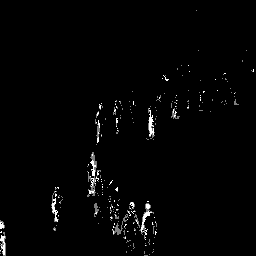

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test001 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(59, 151)]
GT Inverse Tuples: [(0, 59), (151, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6_

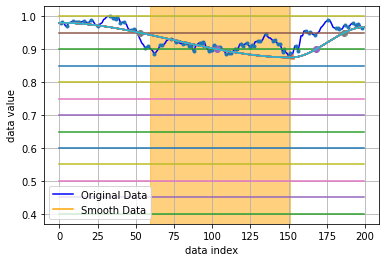

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


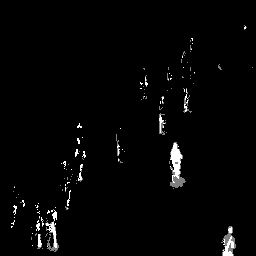

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test002 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(49, 174)]
GT Inverse Tuples: [(0, 49), (174, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6_

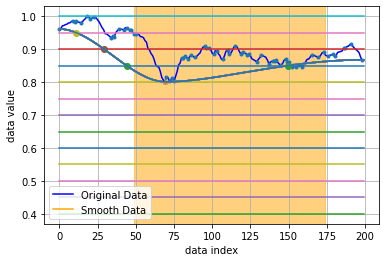

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


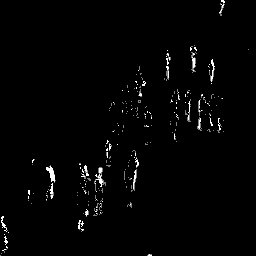

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test003 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(90, 199)]
GT Inverse Tuples: [(0, 90)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
==

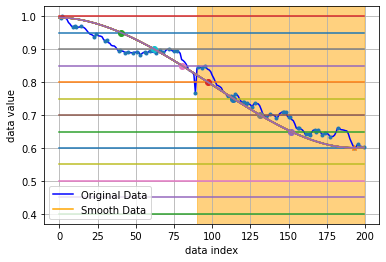

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


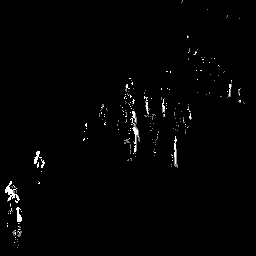

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test004 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 167)]
GT Inverse Tuples: [(167, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


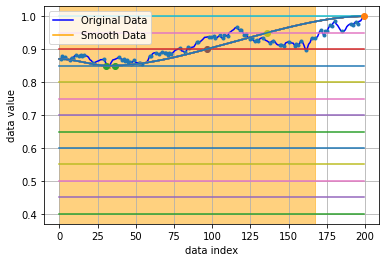

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


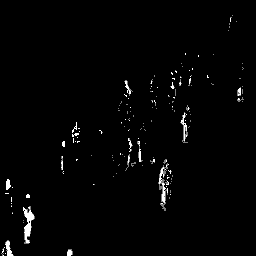

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test005 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(4, 138), (139, 199)]
GT Inverse Tuples: [(0, 4), (138, 139)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Thresh

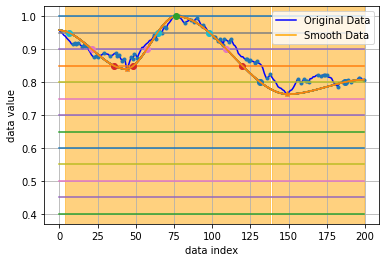

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


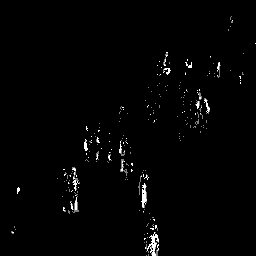

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test006 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 99), (109, 199)]
GT Inverse Tuples: [(99, 109)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6_

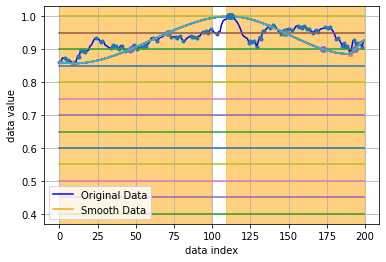

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


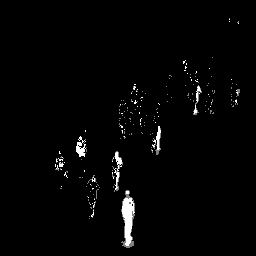

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test007 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 174)]
GT Inverse Tuples: [(174, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


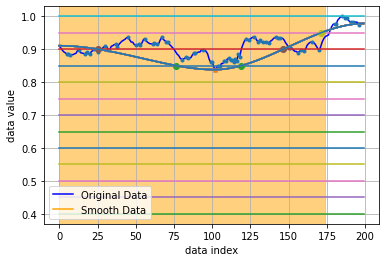

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


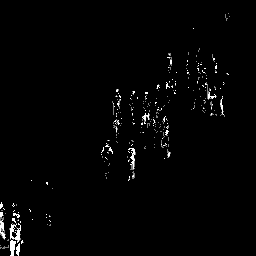

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test008 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 93), (149, 199)]
GT Inverse Tuples: [(93, 149)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6_

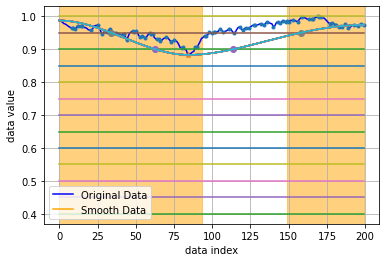

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


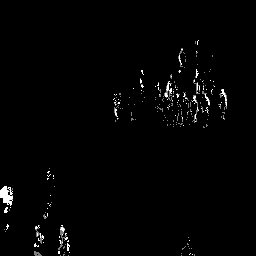

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test009 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 47)]
GT Inverse Tuples: [(47, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
==

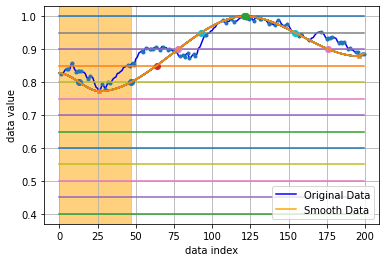

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


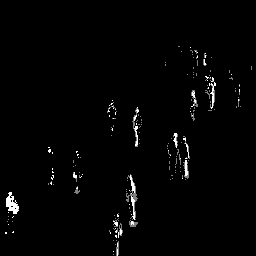

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test010 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 139)]
GT Inverse Tuples: [(139, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


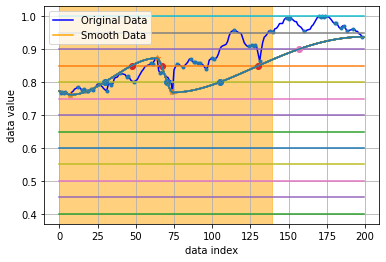

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


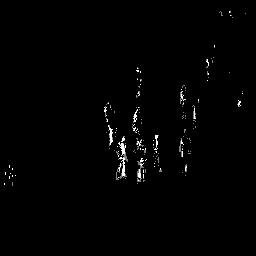

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test011 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(114, 199)]
GT Inverse Tuples: [(0, 114)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


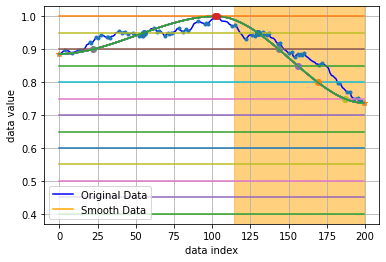

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


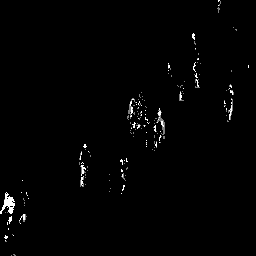

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test012 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(129, 199)]
GT Inverse Tuples: [(0, 129)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
94.40735858192436 131.2422809424764
_____

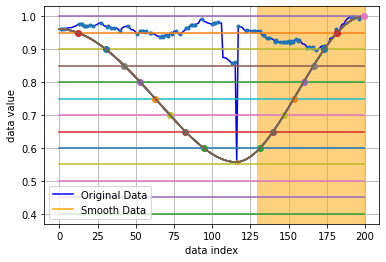

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


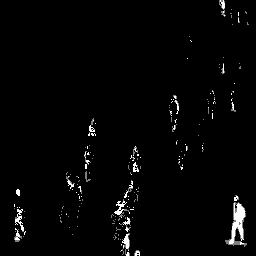

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test013 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 155)]
GT Inverse Tuples: [(155, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


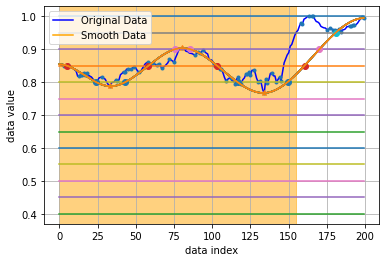

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


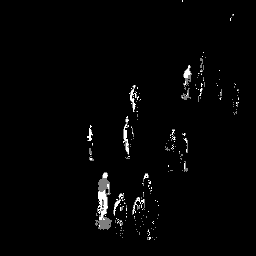

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test014 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 199)]
GT Inverse Tuples: []
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
==========

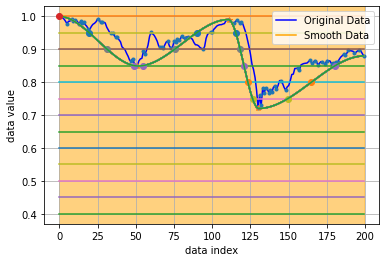

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


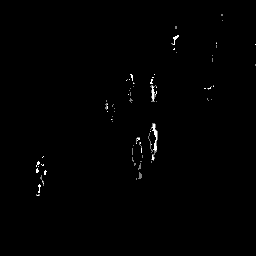

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test015 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(137, 199)]
GT Inverse Tuples: [(0, 137)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


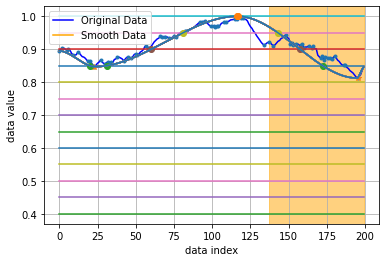

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


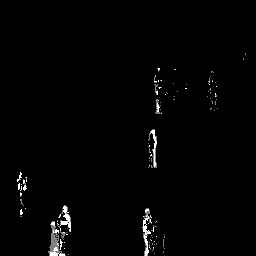

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test016 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(49, 59), (122, 199)]
GT Inverse Tuples: [(0, 49), (59, 122)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Thresh

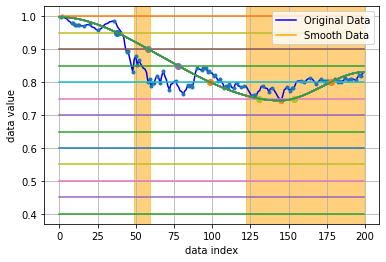

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


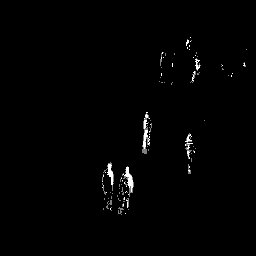

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test017 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 46)]
GT Inverse Tuples: [(46, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
==

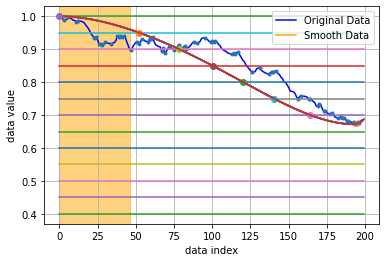

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


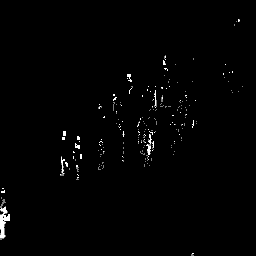

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test018 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(53, 119), (159, 194)]
GT Inverse Tuples: [(0, 53), (119, 159), (194, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR 

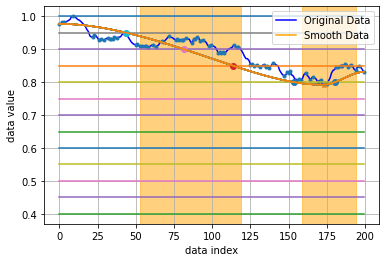

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


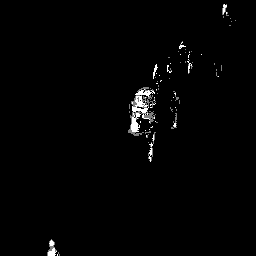

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test019 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(63, 137)]
GT Inverse Tuples: [(0, 63), (137, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6_

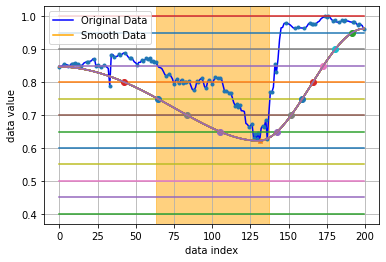

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


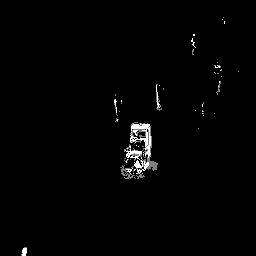

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test020 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(44, 174)]
GT Inverse Tuples: [(0, 44), (174, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
70.84273076478866 87.46552568162129
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Intersect x, y   =   70.84273076478866 , 87.46552568162129
Reference p, q   =   44 

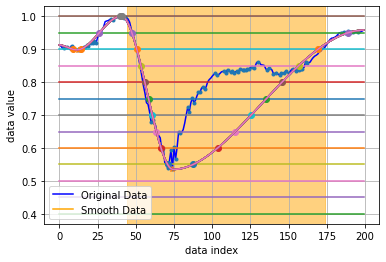

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


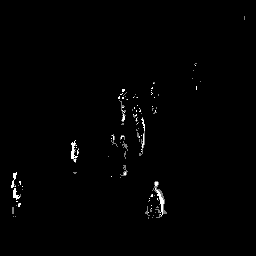

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test021 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(30, 199)]
GT Inverse Tuples: [(0, 30)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
==

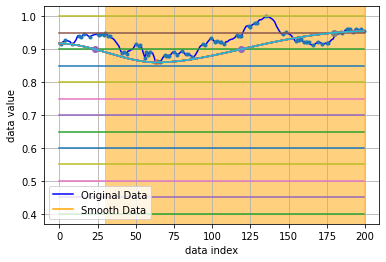

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


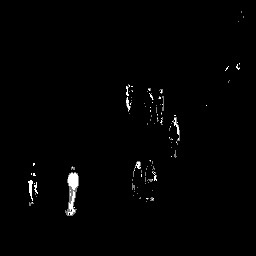

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test022 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(15, 106), (171, 199)]
GT Inverse Tuples: [(0, 15), (106, 171)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Thre

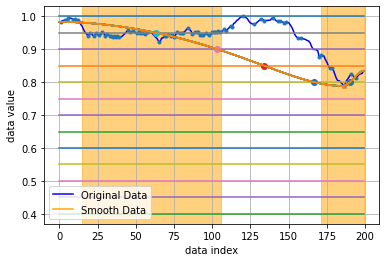

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


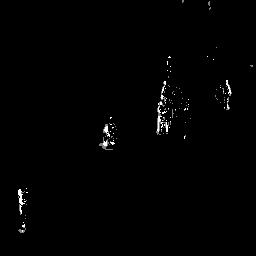

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test023 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(7, 199)]
GT Inverse Tuples: [(0, 7)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
====

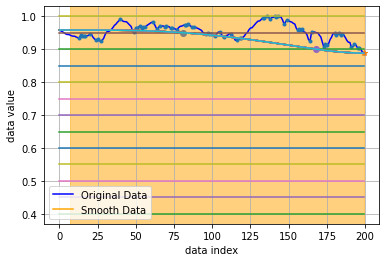

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


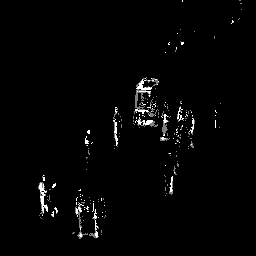

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test024 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 170)]
GT Inverse Tuples: [(170, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
150.1075992937048 168.3509254625597
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Intersect x, y   =   150.1075992937048 , 168.3509254625597
Reference p, q   =   0 , 170
Overl

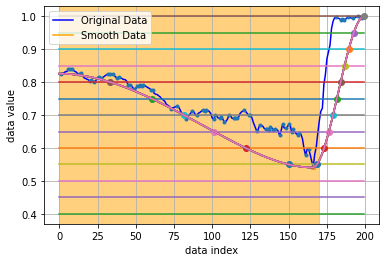

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


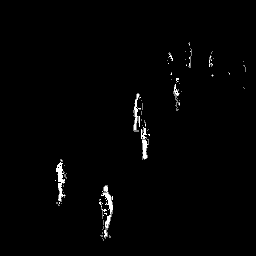

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test025 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(39, 134)]
GT Inverse Tuples: [(0, 39), (134, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6_

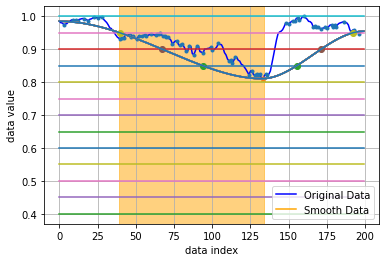

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


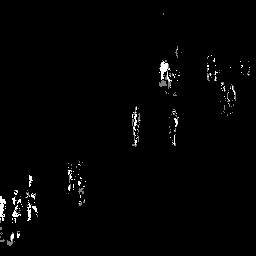

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test026 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(76, 199)]
GT Inverse Tuples: [(0, 76)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
==

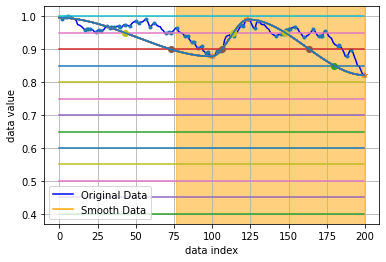

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


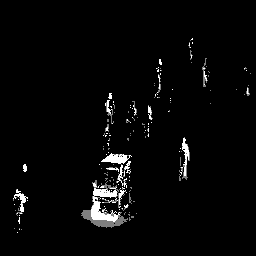

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test027 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(9, 121)]
GT Inverse Tuples: [(0, 9), (121, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
98.33352241242642 124.03535865215038
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Intersect x, y   =   98.33352241242642 , 124.03535865215038
Reference p, q   =   9 ,

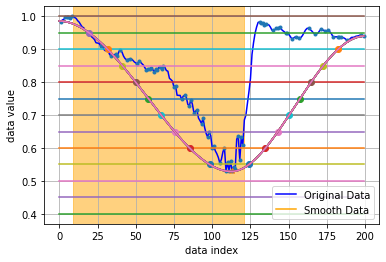

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


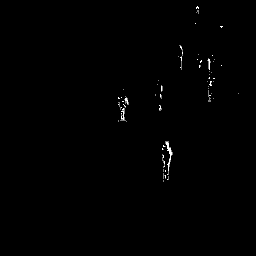

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test028 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(104, 199)]
GT Inverse Tuples: [(0, 104)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


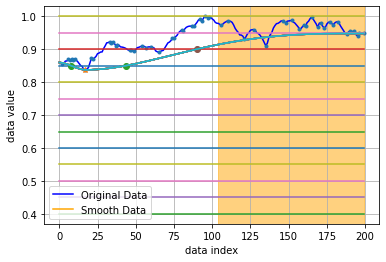

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


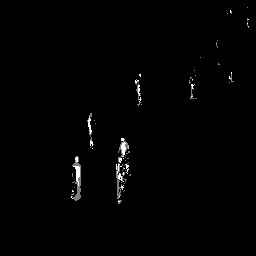

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test029 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 14), (44, 112)]
GT Inverse Tuples: [(14, 44), (112, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Thresh

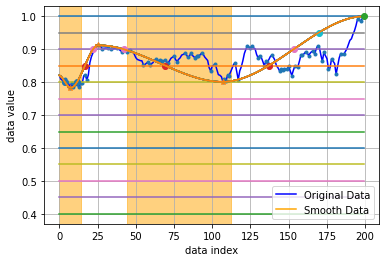

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


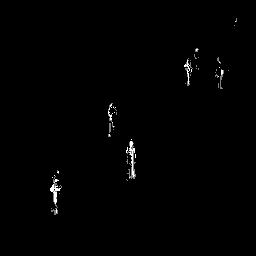

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test030 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(174, 199)]
GT Inverse Tuples: [(0, 174)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


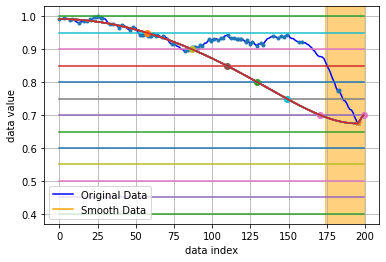

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


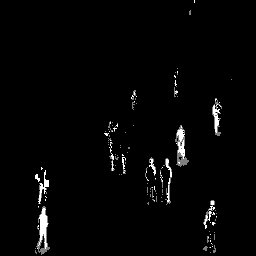

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test031 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 179)]
GT Inverse Tuples: [(179, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


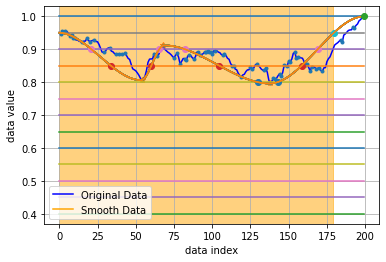

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


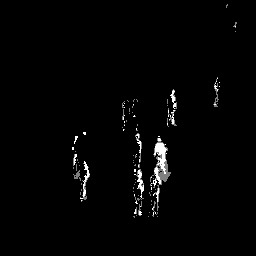

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test032 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 51), (64, 114)]
GT Inverse Tuples: [(51, 64), (114, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Thresh

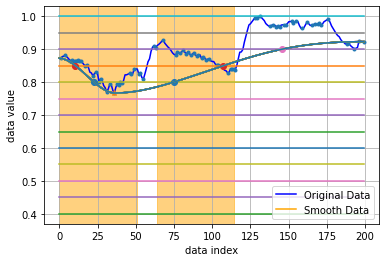

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


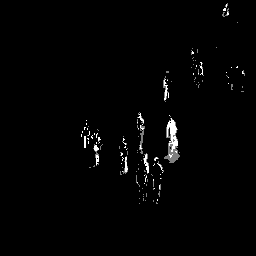

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test033 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 174)]
GT Inverse Tuples: [(174, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


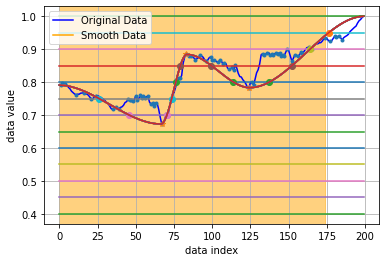

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


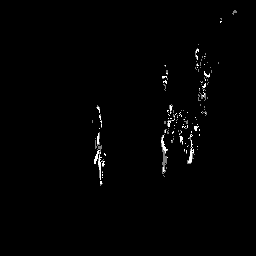

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test034 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(0, 120)]
GT Inverse Tuples: [(120, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________


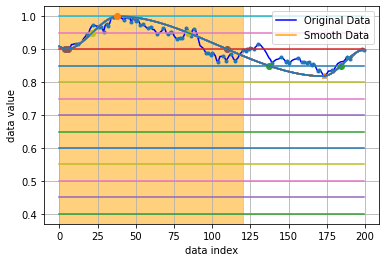

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


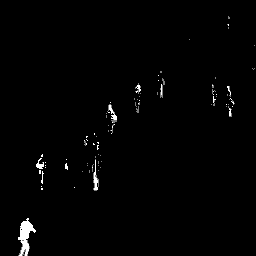

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test035 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(85, 199)]
GT Inverse Tuples: [(0, 85)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6__________
==

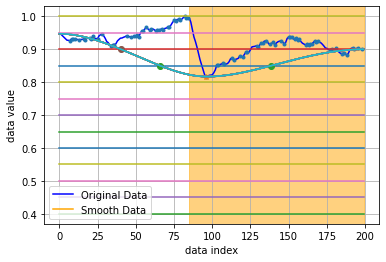

Appended test
(210, 256, 256, 1)
BGS show(210, 256, 256, 1)


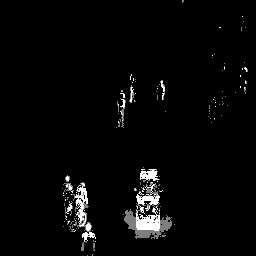

Appended test
(210, 256, 256, 1)
(210, 256, 256, 1)
Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test036 data set loaded
==============Without BG Masked==============
(200,)
GT Tuples: [(14, 107)]
GT Inverse Tuples: [(0, 14), (107, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.6_

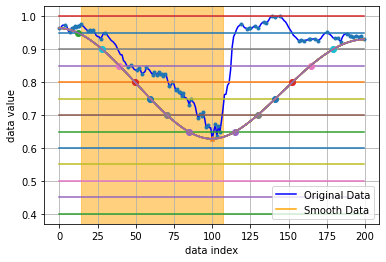

total_ref_gt_arr :[92, 125, 109, 167, 194, 189, 174, 143, 47, 139, 85, 70, 155, 199, 62, 87, 46, 101, 74, 130, 169, 119, 192, 170, 95, 123, 112, 95, 82, 25, 179, 101, 174, 120, 114, 93]
total_ref_gti_arr :[107, 74, 90, 32, 5, 10, 25, 56, 152, 60, 114, 129, 44, 0, 137, 112, 153, 98, 125, 69, 30, 80, 7, 29, 104, 76, 87, 104, 117, 174, 20, 98, 25, 79, 85, 106]




















































































































































































































































































































































































































































































[4351. 4351. 4351. 4351. 4351. 4351. 4351. 4351. 4351. 4351. 4351. 4351.
 4351.]
[2813. 2813. 2813. 2813. 2813. 2813. 2813. 2813. 2813. 2813. 2813. 2813.
 2813.]
(13,)
(13,

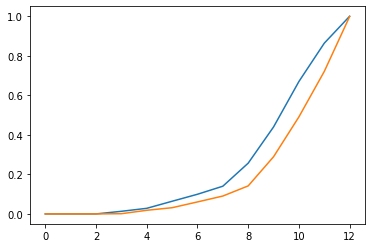

In [7]:
def build_model_aae():
  
    model_enc = load_model(conf.cwdir+"/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_dec = load_model(conf.cwdir+"/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_disc = load_model(conf.cwdir+"/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    #model_enc = load_model("/content/drive/My Drive/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_dec = load_model("/content/drive/My Drive/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_disc = load_model("/content/drive/My Drive/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_ae.compile(optimizer=Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), loss="mse")
#"/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/model.hdf5"

#model_ae = load_model("/content/drive/My Drive/VAE/model1.hdf5",custom_objects={'LayerNormalization': LayerNormalization})

def evaluate_dis(sequences, model, id, dt):
    fooling_loss = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    sa = (fooling_loss - np.min(fooling_loss)) / (np.max(fooling_loss))
    sr = 1.0 - sa

    with open(join("/content/drive/My Drive/", 'sr_score.csv'), mode='a') as f:
        writer = csv.writer(f)
        writer.writerow([float(x[0]) for x in sr])
        f.close()

    threshold_abs = threshold# np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        fill_gt_ped1(sr, id, 'red', threshold_abs)
    elif dt == 2:
        fill_gt_ped2(sr, id, 'red', threshold_abs)
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_dis(t)')
    #plt.xlabel('frame t')
    #plt.show()

def get_clips(test):
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :]
        sequences[i] = clip
    return sequences


def mask_array(bg_list):

    for p in range(0, bg_list.shape[0]):
        for r in range(256):
            for c in range(256):
                if bg_list[p][r][c] > 0:
                    bg_list[p][r][c] = 1
                else:
                    bg_list[p][r][c] = 0

    bg_list[0, :, :] = 0
    return bg_list

def evaluate_ae(sequences, model, id, dt, bg_list=[], mask=1):
  
    sz = len(sequences)

    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    #print(bg_list[10])

    masked_bg = mask_array(bg_list)
    bg_clips = get_clips(masked_bg)
    
    sequences = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], sequences.shape[2], sequences.shape[3]))
    reconstructed_sequences = np.reshape(reconstructed_sequences, (reconstructed_sequences.shape[0], reconstructed_sequences.shape[1], reconstructed_sequences.shape[2], reconstructed_sequences.shape[3]))

    if mask == 1:
        print("==============With BG Masked==============")
        sq_masked = np.multiply(sequences, bg_clips)
        rec_masked = np.multiply(reconstructed_sequences, bg_clips)
    else:
        print("==============Without BG Masked==============")
        sq_masked = sequences
        rec_masked = reconstructed_sequences

    #bg_weights = np.add(np.ones(bg_clips.shape), bg_clips)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sq_masked[i], rec_masked[i])) for i in range(0,sz)])
    #sequences_reconstruction_cost = np.array([np.linalg.norm(np.multiply(bg_weights[i],np.subtract(sequences[i], reconstructed_sequences[i]))) for i in range(0,sz)])


    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost))

    
    sr = 1 - sa
    #threshold_abs = threshold#np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = fill_gt_ped1(sr, id, 'orange')
    elif dt == 2:
        TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = fill_gt_ped2(sr, id, 'orange')
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_ae(t)')
    #plt.xlabel('frame t')
    #plt.show()
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti

def load_input_data_list():
    path = join("/content/drive/My Drive/", 'sr_score.csv')
    InputDataList = LoadData(path)
    return InputDataList


def get_persistance(InputData):
  #~ This simple call is all you need to compute the extrema of the given data and their persistence.
  ExtremaAndPersistence = RunPersistence(InputData)

  #~ Keep only those extrema with a persistence larger than 10.
  Filtered = [t for t in ExtremaAndPersistence if ExtremaAndPersistence[1] > 50]
  print(ExtremaAndPersistence)
  print(Filtered)
  #~ Sort the list of extrema by persistence.
  #Sorted = sorted(Filtered, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[1])

  return Filtered


conf.reconfig(new_name="Conv2DLSTM_AAE_PED1", batch_size=4, epochs=100, retrain=1)




def edge_detect(gray):
    edges1 = np.uint8(gray)
    # Using the Canny filter to get contours
    #edges = cv2.Canny(edges1, 20, 30)
    
    # Using the Canny filter with different parameters
    edges_high_thresh = cv2.Canny(edges1, 160, 200)
    kernel = np.zeros((5,5),np.uint8)
    kernel2 = np.zeros((2,2),np.uint8)

    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(images, cv2.MORPH_CLOSE, kernel2)
    # Stacking the images to print them together
    # For comparison
    #images = np.hstack((gray, edges, edges_high_thresh))

    #kernel = np.ones((3,3), np.uint8) 
    #fg_mask = cv2.erode(edges_high_thresh, kernel, iterations=2)
    # Display the resulting frame
    #cv2_imshow(images)
    return images

    

def connected_comp(img):

    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    #connectedComponentswithStats yields every seperated component with information on each of them, such as size
    #the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
    min_size = 10  

    #your answer image
    img2 = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    return img2

def get_background_subtr(test_case):
    print("BGS show" + str(np.array(test_case).shape))

    subtractor = cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=50, detectShadows=True)
    bg_list = []
    for frame in test_case:
        frame = np.reshape(frame, (256, 256))*256
        #edge_mask = edge_detect(frame)
        #bg_mask = connected_comp(edge_mask)
        bg_mask = subtractor.apply(frame)
        #bg_mask = connected_comp(bg_mask)
        #bg_mask = edge_detect(bg_mask)
        #edge_mask[0] = np.zeros(edge_mask[0].shape)
        kernel = np.ones((5,5), np.uint8) 
        fg_mask = cv2.erode(bg_mask, kernel, iterations=2)
        fg_mask = cv2.dilate(fg_mask, kernel, iterations=5)
        fg_mask = bg_mask/255.0
        #fg_mask = mask
        #cv2_imshow(fg_mask)
        #print(fg_mask)
        bg_list.append(fg_mask)
        #key = cv2.waitKey(30)
        #if key == 27:
        #    break
    cv2_imshow(bg_list[100]*255.0)
    #cv2.destroyAllWindows()
    #print(bg_list)
    return np.array(bg_list)


def show_bgs(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    return get_background_subtr(test)


TPR_FOR_CASES = []
FPR_FOR_CASES = []
total_ref_gt_arr = []
total_ref_gti_arr = []
#print(bg_list[10])
for i in range(1,37):
  if i < 10:
    img_num = "00"+str(i)
  elif i < 100:
    img_num = "0"+str(i)
  else:
    img_num = str(i) 

  #if img_num == "017":
  #  continue

  bg_list = show_bgs("Test"+img_num)
  
  
  test_cases_dir = "Test"+img_num
  test_cases = get_test_sequences(test_cases_dir)
  #test_cases = np.array(prepend_10_clips(test_cases))
  print("Test cases shape: "+str(np.array(test_cases).shape))
  print("Test"+img_num+" data set loaded")
  #evaluate_dis(test_cases, model_enc_disc, i, 1)
  #sorted_sr = get_persistance(np.array([x[0] for x in sr_dis], dtype=float))
  #print(sorted_sr)
  #break
  TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = evaluate_ae(test_cases, model_ae, i, 1, bg_list, 0)
  TPR_FOR_CASES.append(TPR_ARR)
  FPR_FOR_CASES.append(FPR_ARR)
  total_ref_gt_arr.append(total_ref_gt)
  total_ref_gti_arr.append(total_ref_gti)
  
  #evaluate_ae(test_cases, model_ae, i, 1, bg_list, 0)

  #sr_comb = (sr_dis + sr_ae)*0.5
  #sr_comb = []

  continue

print("total_ref_gt_arr :"+str(total_ref_gt_arr))
print("total_ref_gti_arr :"+str(total_ref_gti_arr))


TPR_FOR_CASES = np.array(TPR_FOR_CASES)
FPR_FOR_CASES = np.array(FPR_FOR_CASES)
i=0
j=0
TPR_ADD = np.zeros((TPR_FOR_CASES[0].shape[0],))
TP_REF_ADD = np.zeros(TPR_ADD.shape) 
for id, TPR_CASE in enumerate(TPR_FOR_CASES):

    for i, __ in enumerate(TPR_CASE):
        TPR_ADD[i] = TPR_ADD[i]+TPR_CASE[i]
        print()
        TP_REF_ADD[i] = TP_REF_ADD[i]+total_ref_gt_arr[id]


id=0

FPR_ADD = np.zeros((FPR_FOR_CASES[0].shape[0],))
FP_REF_ADD = np.zeros(FPR_ADD.shape) 
for id, FPR_CASE in enumerate(FPR_FOR_CASES):

    for j, __ in enumerate(FPR_CASE):
        FPR_ADD[j] = FPR_ADD[j]+FPR_CASE[j]
        FP_REF_ADD[j] = FP_REF_ADD[j]+total_ref_gti_arr[id]


print(TP_REF_ADD)
print(FP_REF_ADD)

TPR_PLOT = np.divide(TPR_ADD, TP_REF_ADD)
FPR_PLOT = np.divide(FPR_ADD, FP_REF_ADD)

print(TPR_PLOT.shape)
print(FPR_PLOT.shape)

plt.plot(TPR_PLOT)
plt.plot(FPR_PLOT)
plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from shapely.geometry import LineString

def getEER_Thresh(x, f, g):

    plt.plot(x, f, "o")
    plt.plot(x, f, color="blue")
    plt.plot(x, g, "r--", color="gray")

    first_line = LineString(np.column_stack((x, f)))
    second_line = LineString(np.column_stack((x, g)))
    intersection = first_line.intersection(second_line)
    print("Intersection")
    #print(intersection)
    x_list = []
    if intersection.geom_type == 'MultiPoint':
        plt.plot(*LineString(intersection).xy, "o")
        plt.plot([0, 0.1, 0.2, 0.3, 1], [0, 0.1, 0.2, 0.3, 1], "r--")
        print("Multipoint")
        print(*LineString(intersection).xy[0])
        for x_point in LineString(intersection).xy[0]:
            x_list.append(x_point)
    elif intersection.geom_type == 'Point':
        plt.plot(*intersection.xy, "o")
        plt.plot([0, 0.1, 0.2, 0.3, 1], [0, 0.1, 0.2, 0.3, 1], "r--")
        print("Point")
        print(*intersection.xy[0])
        x_list.append(*intersection.xy[0])

    x_arr = np.array(x_list)
    #print("X_LIST")
    #print(x_arr)
    return x_arr

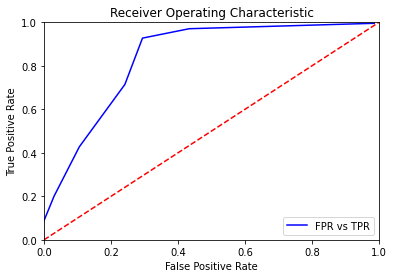

TPR
[0, 0, 0, 0, 0.069767441860465, 0.232558139534884, 0.372093023255814, 0.744186046511628, 0.953488372093023, 0.953488372093023, 1]
FPR
[0, 0, 0, 0, 0, 0.022222222222222, 0.111111111111111, 0.222222222222222, 0.377777777777778, 0.377777777777778, 1]
Intersection
Point
0.23654390934844177
1
EER = 0.23654390934844177
EER Threshold =  0.7634560906515582
AUC = 0.8320413436692506


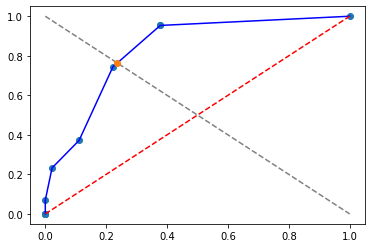

In [9]:


plt.title('Receiver Operating Characteristic')
TPR = [0,	0,	0,	0,	0.069767441860465,	0.232558139534884,	0.372093023255814,	0.744186046511628,	0.953488372093023,	0.953488372093023, 1]
FPR = [0,	0,	0,	0,	0,	0.022222222222222,	0.111111111111111,	0.222222222222222,	0.377777777777778,	0.377777777777778, 1]

plt.plot(savgol_filter(FPR, 5, 3), savgol_filter(TPR, 5, 3), 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area

#TPR = np.array(savgol_filter(TPR, 5, 3))
#FPR = np.array(savgol_filter(FPR, 5, 3))
TPR = np.array(TPR)
FPR = np.array(FPR)
eer_arr = getEER_Thresh(FPR, TPR, 1-FPR)
print(eer_arr.size)
eer_threshold = 1 -eer_arr[0]
print("EER = "+str(eer_arr[0]))
print("EER Threshold =  "+str(eer_threshold))
print("AUC = "+str(integrate(FPR, TPR)))

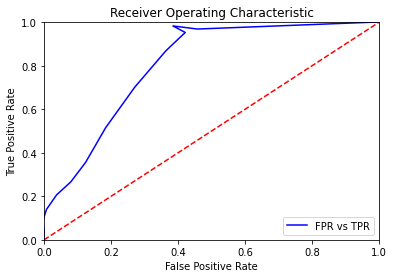

TPR
[0, 0, 0, 0, 0.05, 0.075, 0.15, 0.2, 0.275, 0.35, 0.5, 0.725, 0.85, 0.975, 0.975, 0.975, 1]
FPR
[0, 0, 0, 0, 0, 0, 0, 0.040816326530612, 0.081632653061225, 0.122448979591837, 0.183673469387755, 0.26530612244898, 0.36734693877551, 0.428571428571429, 0.428571428571429, 0.428571428571429, 1]
Intersection
Point
0.2696629213483148
1
EER = 0.2696629213483148
EER Threshold =  0.7303370786516852
AUC = 0.8061224489795917


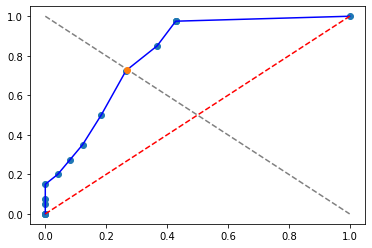

In [10]:

plt.title('Receiver Operating Characteristic')
TPR = [0,	0,	0,	0,	0.05,	0.075,	0.15,	0.2,	0.275,	0.35,	0.5,	0.725,	0.85,	0.975,	0.975,	0.975, 1]
FPR = [0,	0,	0,	0,	0, 0, 0,	0.040816326530612,	0.081632653061225,	0.122448979591837,	0.183673469387755,	0.26530612244898,	0.36734693877551,	0.428571428571429,	0.428571428571429,	0.428571428571429, 1]
plt.plot(savgol_filter(FPR, 5, 3), savgol_filter(TPR, 5, 3), 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area


#TPR = np.array(savgol_filter(TPR, 5, 3))
#FPR = np.array(savgol_filter(FPR, 5, 3))
TPR = np.array(TPR)
FPR = np.array(FPR)
eer_arr = getEER_Thresh(FPR, TPR, 1-FPR)
print(eer_arr.size)
eer_threshold = 1 -eer_arr[0]
print("EER = "+str(eer_arr[0]))
print("EER Threshold =  "+str(eer_threshold))
print("AUC = "+str(integrate(FPR, TPR)))

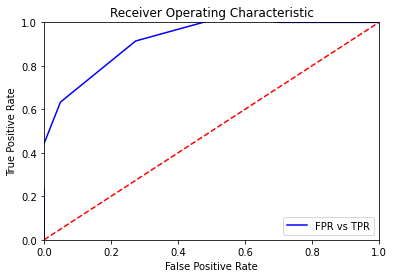

TPR
[0, 0, 0, 0, 0.083333333333333, 0.083333333333333, 0.083333333333333, 0.166666666666667, 0.25, 0.333333333333333, 0.583333333333333, 1, 1, 1, 1, 1, 1]
FPR
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.285714285714286, 0.571428571428571, 0.714285714285714, 0.714285714285714, 0.714285714285714, 1]
Intersection
Point
0.16949152542372894
1
EER = 0.16949152542372894
EER Threshold =  0.8305084745762711
AUC = 0.9404761904761904


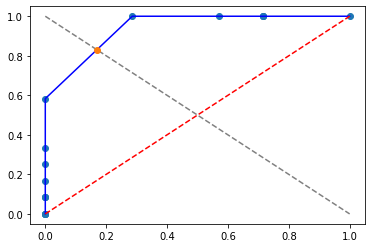

In [11]:



TPR = [0,	0,	0,	0,	0.083333333333333,	0.083333333333333,	0.083333333333333,	0.166666666666667,	0.25,	0.333333333333333,	0.583333333333333,	1,	1,	1,	1,	1, 1]
FPR = [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0.285714285714286,	0.571428571428571,	0.714285714285714,	0.714285714285714,	0.714285714285714, 1]
plt.title('Receiver Operating Characteristic')
plt.plot(savgol_filter(FPR, 5, 3), savgol_filter(TPR, 5, 3), 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area
#TPR = np.array(savgol_filter(TPR, 5, 3))
#FPR = np.array(savgol_filter(FPR, 5, 3))
TPR = np.array(TPR)
FPR = np.array(FPR)
eer_arr = getEER_Thresh(FPR, TPR, 1-FPR)
print(eer_arr.size)
eer_threshold = 1 -eer_arr[0]
print("EER = "+str(eer_arr[0]))
print("EER Threshold =  "+str(eer_threshold))
print("AUC = "+str(integrate(FPR, TPR)))

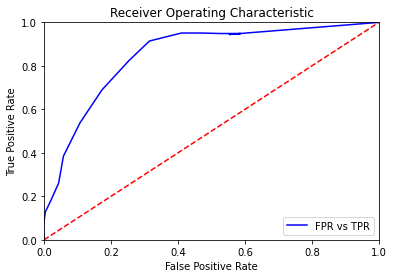

TPR
[0, 0, 0, 0.076923076923077, 0.128205128205128, 0.179487179487179, 0.256410256410256, 0.384615384615385, 0.538461538461538, 0.692307692307692, 0.82051282051282, 0.923076923076923, 0.948717948717949, 0.948717948717949, 0.948717948717949, 0.948717948717949, 0.948717948717949, 0.948717948717949, 0.948717948717949, 1]
FPR
[0, 0, 0, 0, 0, 0.021739130434783, 0.043478260869565, 0.065217391304348, 0.086956521739131, 0.195652173913043, 0.239130434782609, 0.326086956521739, 0.391304347826087, 0.5, 0.5, 0.565217391304348, 0.58695652173913, 0.58695652173913, 0.58695652173913, 1]
Intersection
Point
0.22402597402597416
1
EER = 0.22402597402597416
EER Threshold =  0.7759740259740259
AUC = 0.8497770345596432


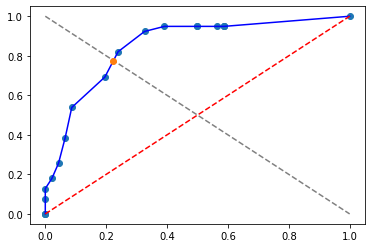

In [12]:
#bg sub ped1
TPR =[0,	0,	0,	0.076923076923077,	0.128205128205128,	0.179487179487179,	0.256410256410256,	0.384615384615385,	0.538461538461538	,0.692307692307692,	0.82051282051282,	0.923076923076923,	0.948717948717949,	0.948717948717949,	0.948717948717949	,0.948717948717949,	0.948717948717949,	0.948717948717949	,0.948717948717949, 1]
FPR =[0,	0,	0,	0,	0,	0.021739130434783,	0.043478260869565,	0.065217391304348,	0.086956521739131,	0.195652173913043	,0.239130434782609	,0.326086956521739	,0.391304347826087,	0.5	,0.5,	0.565217391304348,	0.58695652173913,	0.58695652173913	,0.58695652173913, 1]

plt.title('Receiver Operating Characteristic')
plt.plot(savgol_filter(FPR, 5, 3), savgol_filter(TPR, 5, 3), 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area
#TPR = np.array(savgol_filter(TPR, 5, 3))
#FPR = np.array(savgol_filter(FPR, 5, 3))
TPR = np.array(TPR)
FPR = np.array(FPR)
eer_arr = getEER_Thresh(FPR, TPR, 1-FPR)
print(eer_arr.size)
eer_threshold = 1 -eer_arr[0]
print("EER = "+str(eer_arr[0]))
print("EER Threshold =  "+str(eer_threshold))
print("AUC = "+str(integrate(FPR, TPR)))

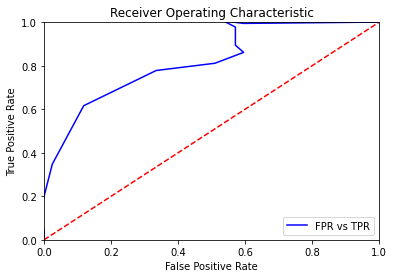

TPR
[0, 0, 0.083333333333333, 0.083333333333333, 0.333333333333333, 0.666666666666667, 0.75, 0.833333333333333, 0.833333333333333, 0.916666666666667, 0.916666666666667, 0.916666666666667, 1, 1, 1, 1]
FPR
[0, 0, 0, 0, 0, 0.142857142857143, 0.285714285714286, 0.571428571428571, 0.571428571428571, 0.571428571428571, 0.571428571428571, 0.571428571428571, 0.571428571428571, 0.571428571428571, 0.571428571428571, 1]
Intersection
Point
0.26315789473684215
1
EER = 0.26315789473684215
EER Threshold =  0.7368421052631579
AUC = 0.8273809523809523


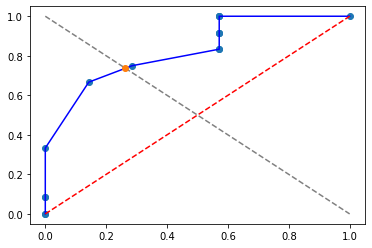

In [13]:
#bg sub ped2

TPR = [0,	0,	0.083333333333333,	0.083333333333333,	0.333333333333333,	0.666666666666667,	0.75,	0.833333333333333,	0.833333333333333,	0.916666666666667,	0.916666666666667,	0.916666666666667,	1,	1,	1, 1]

FPR = [0,	0,	0,	0,	0,	0.142857142857143,	0.285714285714286,	0.571428571428571,	0.571428571428571,	0.571428571428571,	0.571428571428571,	0.571428571428571,	0.571428571428571,	0.571428571428571,	0.571428571428571, 1]


plt.title('Receiver Operating Characteristic')
plt.plot(savgol_filter(FPR, 5, 3), savgol_filter(TPR, 5, 3), 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area
#TPR = np.array(savgol_filter(TPR, 5, 3))
#FPR = np.array(savgol_filter(FPR, 5, 3))
TPR = np.array(TPR)
FPR = np.array(FPR)
eer_arr = getEER_Thresh(FPR, TPR, 1-FPR)
print(eer_arr.size)
eer_threshold = 1 -eer_arr[0]
print("EER = "+str(eer_arr[0]))
print("EER Threshold =  "+str(eer_threshold))
print("AUC = "+str(integrate(FPR, TPR)))

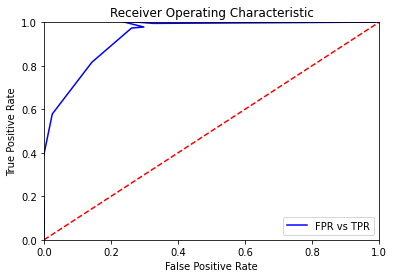

TPR
[0, 0, 0, 0, 0.083333333333333, 0.083333333333333, 0.083333333333333, 0.083333333333333, 0.166666666666667, 0.333333333333333, 0.5, 0.916666666666667, 0.916666666666667, 1, 1, 1, 1]
FPR
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.142857142857143, 0.285714285714286, 0.285714285714286, 0.285714285714286, 0.285714285714286, 1]
Intersection
Point
0.12765957446808512
1
EER = 0.12765957446808512
EER Threshold =  0.8723404255319149
AUC = 0.9464285714285714


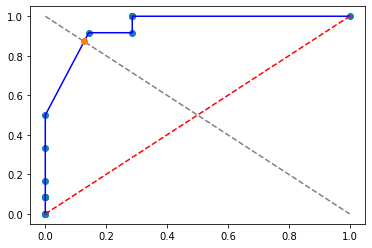

In [14]:
#bg partial sub

TPR = [0,	0,	0,	0,	0.083333333333333,	0.083333333333333,	0.083333333333333,	0.083333333333333,	0.166666666666667	,0.333333333333333	,0.5	,0.916666666666667,	0.916666666666667,	1,	1,	1, 1]
FPR = [0	,0	,0	,0	,0	,0	,0	,0	,0	,0	,0	,0.142857142857143	,0.285714285714286	,0.285714285714286	,0.285714285714286	,0.285714285714286,1]
plt.title('Receiver Operating Characteristic')
plt.plot(savgol_filter(FPR, 5, 3), savgol_filter(TPR, 5, 3), 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area
#TPR = np.array(savgol_filter(TPR, 5, 3))
#FPR = np.array(savgol_filter(FPR, 5, 3))
TPR = np.array(TPR)
FPR = np.array(FPR)
eer_arr = getEER_Thresh(FPR, TPR, 1-FPR)
print(eer_arr.size)
eer_threshold = 1 -eer_arr[0]
print("EER = "+str(eer_arr[0]))
print("EER Threshold =  "+str(eer_threshold))
print("AUC = "+str(integrate(FPR, TPR)))